In [1]:
#Sources used: https://towardsdatascience.com/transfer-learning-from-pre-trained-models-f2393f124751
#              https://medium.com/@ODSC/how-to-leverage-pre-trained-layers-in-image-classification-31fb9b8cdd0
#Also based this a lot on the work of the other teammates too :)
import numpy as np
import pandas as pd
from pandas import DataFrame, Series
import datetime
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import json 
from pandas.io.json import json_normalize
import seaborn as sns

from PIL import Image
from io import BytesIO
import requests

import tensorflow
import keras
from keras.applications import vgg16, inception_v3, resnet50, mobilenet
from keras import models
# imports for loading and viewing image 
from keras.preprocessing.image import load_img
from keras.preprocessing.image import img_to_array
from keras.applications.imagenet_utils import decode_predictions

Using TensorFlow backend.


In [2]:
# read in data from our github repository
data = pd.read_json ("https://raw.githubusercontent.com/TiernonRR/Dank_AIT/master/text%20analysis/dank_cleaned.json?token=AKIVLTSIA7XW3EYKE27VKLK6XPLYK")
data['ups_normed'] = data['ups']/data['subscribers']

In [3]:
data.head()

,author,awards,created_utc,text_from_image,words,processed_words,downs,id,is_nsfw,media,subreddit,subscribers,thumbnail.height,thumbnail.thumbnail,thumbnail.width,title,ups,url,ups_normed
1,L71U,[],1584295514,NICE DICK\r\n,Ricardo😎NICE DICK\r\n,"[ricardo, nice, dick]",0,fj5ixk,False,https://i.redd.it/w6acm47gmvm41.jpg,r/dank_meme,743116,136.0,https://b.thumbs.redditmedia.com/PixKjoPWVw738...,140.0,Ricardo😎,35,/r/dank_meme/comments/fj5ixk/ricardo/,0.000047
2,Awesome-ness5,[],1584294841,Nvidia's calling on gaming PC owners to\r\nput...,Gamers AssembleNvidia's calling on gaming PC o...,"[gamer, assemblenvidia, call, game, owner, sys...",0,fj5bzj,False,https://i.redd.it/bqawbb5gkvm41.jpg,r/dank_meme,743116,140.0,https://b.thumbs.redditmedia.com/Fj8eeEt78J-I6...,140.0,Gamers Assemble,11,/r/dank_meme/comments/fj5bzj/gamers_assemble/,0.000015
5,None,[],1584293979,JANUARY\r\nFEBRUARY\r\nMARCH\r\nAPRIL\r\ncnu\r...,2020 in a nutshellJANUARY\r\nFEBRUARY\r\nMARCH...,"[nutshelljanuari, februari, march, april, plag...",0,fj53jo,False,https://i.imgur.com/7LmxYnC.png,r/dank_meme,743116,140.0,default,140.0,2020 in a nutshell,1,/r/dank_meme/comments/fj53jo/2020_in_a_nutshell/,0.000001
7,notaspop,[],1584293653,When you post a low-effort meme\r\nfor fun to ...,I mean.... Not Corona time?When you post a low...,"[mean, corona, time, post, effort, meme, peopl...",0,fj50df,False,https://i.redd.it/v5pea6wwgvm41.jpg,r/dank_meme,743116,140.0,default,140.0,I mean.... Not Corona time?,1,/r/dank_meme/comments/fj50df/i_mean_not_corona...,0.000001
8,Gaunja420,[],1584293617,H A p pyt1A\r\n,WheNH A p pyt1A\r\n,[whenh],0,fj501g,False,https://i.redd.it/809pja1tgvm41.gif,r/dank_meme,743116,140.0,default,140.0,WheN,1,/r/dank_meme/comments/fj501g/when/,0.000001


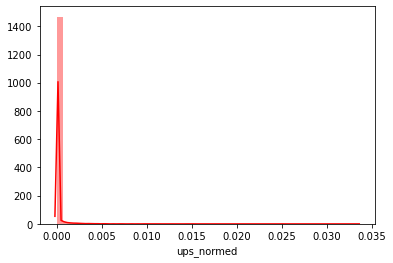

In [4]:
sns.distplot(data['ups_normed'], color='r')

In [5]:
def data_delimit(threshold): #take a percentage, consider all memes that have more upvotes than this percentile to be dank
    data['dank_level'] = data['ups_normed'].apply(lambda x: 1 if x >= data['ups_normed'].quantile(threshold) else 0)

In [6]:
data_delimit(0.95) #considering 5% of memes to be dank

(array([36133.,  1902.]), array([0. , 0.5, 1. ]), <a list of 2 Patch objects>)

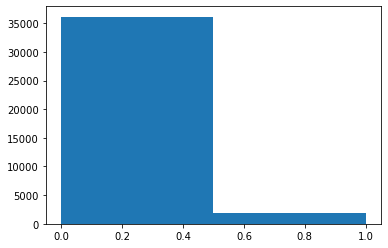

In [7]:
plt.hist(data['dank_level'], bins=2)

In [8]:
data.sort_values(['ups_normed'], ascending=0).head()

,author,awards,created_utc,text_from_image,words,processed_words,downs,id,is_nsfw,media,subreddit,subscribers,thumbnail.height,thumbnail.thumbnail,thumbnail.width,title,ups,url,ups_normed,dank_level
669,SuperUltraRemixHype0,[],1584083761,People Post\r\nBut IJpfotJé\r\n,本当にそうなのPeople Post\r\nBut IJpfotJé\r\n,"[本当にそうなのpeopl, post, ijpfotjé]",0,fhvs1b,False,https://i.redd.it/ogccfkws4em41.jpg,r/dank_meme,743116,71.0,https://b.thumbs.redditmedia.com/IBRGKMm_avigp...,140.0,本当にそうなの,24786,/r/dank_meme/comments/fhvs1b/本当にそうなの/,0.033354,1
5391,Exulton,[],1584164844,Normal people going to the grocery store\r\nan...,"If I was you, I would invest in Macron’s facia...","[invest, macron, facial, peopl, go, groceri, s...",0,fidth0,False,https://i.redd.it/zhrls3jwtkm41.jpg,r/MemeEconomy,1284214,102.0,default,140.0,"If I was you, I would invest in Macron’s facia...",32137,/r/MemeEconomy/comments/fidth0/if_i_was_you_i_...,0.025025,1
2044,Kalanthropos,"[{'giver_coin_reward': 0, 'subreddit_id': None...",1584222240,I DON'T\r\nFEEL WELL\r\no\r\nSAFELY ENDANGERED...,Me🤒irlI DON'T\r\nFEEL WELL\r\no\r\nSAFELY ENDA...,"[ir, feel, safe, endang, breath, sharon, send,...",0,fiq4y7,False,https://i.redd.it/2re87yhkkpm41.jpg,r/me_irl,3662083,140.0,https://b.thumbs.redditmedia.com/sqiXPeTubHjUB...,140.0,Me🤒irl,78463,/r/me_irl/comments/fiq4y7/meirl/,0.021426,1
7146,theonlymexicanman,"[{'giver_coin_reward': None, 'subreddit_id': N...",1584290523,News > World > Europe\r\nCoronavirus: Austria ...,This house ain’t big enough for the six of usN...,"[hous, usnew, world, europ, coronavirus, austr...",0,fj45ih,False,https://i.redd.it/x4s2e60m7vm41.jpg,r/memes,9507486,134.0,https://b.thumbs.redditmedia.com/MhiUkwp78O04E...,140.0,This house ain’t big enough for the six of us,196771,/r/memes/comments/fj45ih/this_house_aint_big_e...,0.020696,1
4923,GoldenToxcitity,"[{'giver_coin_reward': None, 'subreddit_id': N...",1584044109,When you start your first online class after y...,Me_irlWhen you start your first online class a...,"[me_irlwhen, start, onlin, class, school, shut]",0,fhmrfe,False,https://i.redd.it/j0aoeu7wuam41.jpg,r/me_irl,3662085,131.0,https://b.thumbs.redditmedia.com/r4OU221EDsUwD...,140.0,Me_irl,65804,/r/me_irl/comments/fhmrfe/me_irl/,0.017969,1


In [9]:
#Load the VGG model
vgg_model = vgg16.VGG16(weights='imagenet')

#Load the Inception_V3 model
inception_model = inception_v3.InceptionV3(weights='imagenet')

#Load the ResNet50 model
resnet_model = resnet50.ResNet50(weights='imagenet')

#Load the MobileNet model
mobilenet_model = mobilenet.MobileNet(weights='imagenet')

17227776/17225924 [==============================] - 4s 0us/step


In [10]:
row = data.iloc[5]
test_url = row['media']

PIL image size (299, 299)


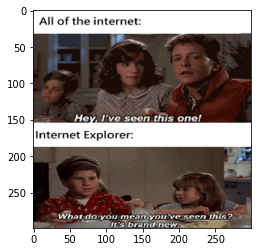

In [11]:
# load an image in PIL format
response = requests.get(test_url)
original = Image.open(BytesIO(response.content))
newsize = (299, 299)
original = original.resize(newsize)
print('PIL image size',original.size)
plt.imshow(original)
plt.show()

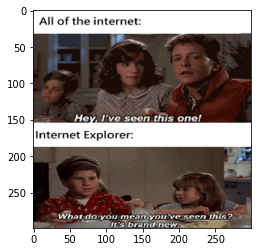

numpy array size (299, 299, 3)


In [12]:
# convert the PIL image to a numpy array
# IN PIL - image is in (width, height, channel)
# In Numpy - image is in (height, width, channel)
numpy_image = img_to_array(original)
plt.imshow(np.uint8(numpy_image))
plt.show()
print('numpy array size',numpy_image.shape)

image batch size (1, 299, 299, 3)


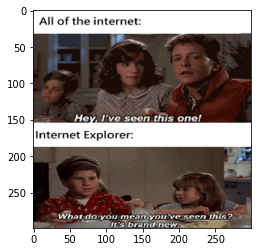

In [13]:
# Convert the image / images into batch format
# expand_dims will add an extra dimension to the data at a particular axis
# We want the input matrix to the network to be of the form (batchsize, height, width, channels)
# Thus we add the extra dimension to the axis 0.
image_batch = np.expand_dims(numpy_image, axis=0)
print('image batch size', image_batch.shape)
plt.imshow(np.uint8(image_batch[0]))

In [14]:
# prepare the image for the inception_v3 model
processed_image = inception_v3.preprocess_input(image_batch.copy())
# get the predicted probabilities for each class
predictions = inception_model.predict(processed_image)
# print predictions
# convert the probabilities to class labels
# We will get top 5 predictions which is the default
label = decode_predictions(predictions)
print(label)

40960/35363 [==================================] - 0s 2us/step
[[('n06359193', 'web_site', 0.9866702), ('n03661043', 'library', 0.0015610496), ('n02992529', 'cellular_telephone', 0.0004958089), ('n04584207', 'wig', 0.0003139874), ('n04501370', 'turnstile', 0.00030115264)]]


In [15]:
#Transfer learning step
num_classes = 2
image_size = 299
inception = inception_v3.InceptionV3(include_top = False, pooling = 'avg', weights = 'imagenet',
                                 input_shape = (image_size, image_size, 3))
inception.summary()

87916544/87910968 [==============================] - 11s 0us/step
Model: "inception_v3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_5 (InputLayer)            (None, 299, 299, 3)  0                                            
__________________________________________________________________________________________________
conv2d_95 (Conv2D)              (None, 149, 149, 32) 864         input_5[0][0]                    
__________________________________________________________________________________________________
batch_normalization_95 (BatchNo (None, 149, 149, 32) 96          conv2d_95[0][0]                  
__________________________________________________________________________________________________
activation_144 (Activation)     (None, 149, 149, 32) 0           batch_normalization_95[0][0]     
_____________________

In [16]:
#Creating own model
model = models.Sequential()
#Add the inception convolutional base model
from keras.layers import Dense
model.add(inception)
model.add(Dense(2, activation = 'softmax'))
model.layers[0].trainable = False
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inception_v3 (Model)         (None, 2048)              21802784  
_________________________________________________________________
dense_1 (Dense)              (None, 2)                 4098      
Total params: 21,806,882
Trainable params: 4,098
Non-trainable params: 21,802,784
_________________________________________________________________


In [17]:
from tensorflow.python.keras.preprocessing.image import ImageDataGenerator
from keras.applications.inception_v3 import preprocess_input
data_generator = ImageDataGenerator(preprocessing_function = preprocess_input, 
                                    horizontal_flip = True)